In [1]:
# Import libraries
import numpy as np
import demes, demesdraw

In [32]:
# Cake model function
def cake_model(Ns,splits,proportions,time_period_merge,time_period_splits,migration_rate=1e-4,yaml_filename=None,plot=True,plot_filename=None):

    # Check arguments
    assert len(splits) == len(proportions) == len(time_period_splits), "Proportions and time period list must be the same length as number of split events."
    assert len(splits)+1 == len(time_period_merge), "Time period merge list must be the same length as number of split events + 1."

    merge_events = len(splits)+1
    assert len(Ns) == merge_events, "Length of Ns list must be equal to number of split events + 1"

    total_time = np.sum(np.array(time_period_merge).sum() + np.array(time_period_splits).sum())

    m = demes.Builder()

    # Add first Ancestor
    m.add_deme("Ancestral",epochs=[dict(start_size=Ns[0], end_time=total_time-time_period_merge[0])])
    current_time = total_time-time_period_merge[0]
    split_b = 1
    previous = ["Ancestral"]

    #
    event = 0 
    split_i = 0
    while current_time > 0:
        if split_b:
            pops = []
            assert splits[split_i] == len(proportions[split_i]), "Proportions list must have the same length as the number of splits"
            for pop_i,proportion in zip(np.arange(splits[split_i]),proportions[split_i]):
                name="Split_" + str(event) + str(pop_i)
                m.add_deme(name,ancestors=previous,start_time=current_time,epochs=[dict(start_size=Ns[event]*proportion,end_time=current_time-time_period_splits[event])])
                pops.append(name)
            previous = pops
            if migration_rate > 0:
                m.add_migration(demes = pops, rate = migration_rate)
            current_time = current_time-time_period_splits[event]
            split_b = 0
            event = event + 1
        else: 
            assert len(previous) == len(list(np.repeat(np.array([1/splits[split_i]]),splits[split_i]))), "Length of ancestors is not equal to proportions"
            name="Merge_" + str(event)
            m.add_deme(name,ancestors=previous,proportions=list(np.repeat(np.array([1/splits[split_i]]),splits[split_i])),start_time=current_time,epochs=[dict(start_size=Ns[event],end_time=current_time-time_period_merge[event])])
            previous = [name]
            current_time = current_time-time_period_merge[event]
            split_b = 1
            split_i = split_i + 1

    # Resolver model
    graph = m.resolve()

    # Check demographic events
    print(graph.discrete_demographic_events()['splits'])

    # option to save to yaml
    if yaml_filename != None:
        demes.dump(graph, yaml_filename, format='yaml', simplified=True)
    
    if plot:
        p = demesdraw.tubes(graph, log_time=False, num_lines_per_migration=3)
        if plot_filename != None:
            p.figure.savefig(plot_filename+".svg")
    
    return graph
    

[Split(parent='Ancestral', children=['Split_02', 'Split_03', 'Split_01', 'Split_00'], time=5100.0), Split(parent='Merge_1', children=['Split_12', 'Split_11', 'Split_10'], time=4000.0), Split(parent='Merge_2', children=['Split_20', 'Split_21'], time=2000.0)]


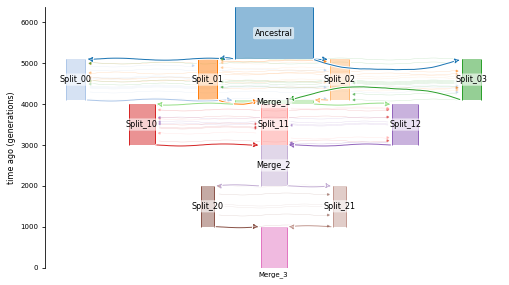

In [33]:
model = cake_model(Ns=[30000,30000,10000,10000],splits=[4,3,2],proportions=[[1/4,1/4,1/4,1/4],[1/3,1/3,1/3],[1/2,1/2]],time_period_merge=[0.3*10000,0.01*10000,0.1*10000,0.1*10000],time_period_splits=[0.1*10000,0.1*10000,0.1*10000])

In [24]:
def size_change(Ns,time_period,yaml_filename=None,plot=True,plot_filename=None):
    
    m = demes.Builder()

    current_time=np.array(time_period).sum()

    epochs = []
    for N,time in zip(Ns,time_period):
        print(current_time)
        epoch = dict(start_size=N,end_time=current_time-time)
        current_time=current_time-time
        epochs.append(epoch)

    m.add_deme("Deme",epochs=epochs)

    # Resolve model
    graph = m.resolve()

    # Check demographic events
    print(epochs)
    
    # option to save to yaml
    if yaml_filename != None:
        demes.dump(graph, yaml_filename, format='yaml', simplified=True)
    
    if plot:
        p = demesdraw.tubes(graph, log_time=True, num_lines_per_migration=3)
        if plot_filename != None:
            p.figure.savefig(plot_filename+".svg")
    

30000.0
20000.0
10000.0
[{'start_size': 10000, 'end_time': 20000.0}, {'start_size': 2000, 'end_time': 10000.0}, {'start_size': 30000, 'end_time': 0.0}]


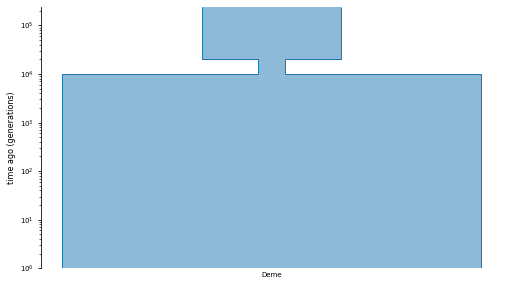

In [25]:
size_change([10000,2000,30000],[0.1*100000,0.1*100000,0.1*100000])